In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Parse Json File

In [59]:
session_id = []
unix_timestamp = []
cities = []
user_id = []
joining_date = []
country = []

with open('in.json', 'r') as f:
    json_data = json.load(f)
    
for item in json_data:
    session_id.append(item['session_id'][0])
    unix_timestamp.append(item['unix_timestamp'][0])
    cities.append(item['cities'][0])
    user_id.append(item['user'][0][0]['user_id'])
    joining_date.append(item['user'][0][0]['joining_date'])
    country.append(item['user'][0][0]['country'])

d = {'session_id': session_id, 'timestamp': unix_timestamp, 'cities': cities, 
            'user_id': user_id, 'joining_date': joining_date, 'country': country}
columns =['session_id', 'timestamp', 'cities', 'user_id', 'joining_date', 'country']

data = pd.DataFrame(d, columns=columns)

#replace empty string with NaN
#data = data.replace(r'^\s*$', np.NaN, regex=True)

data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session_id    20022 non-null  object
 1   timestamp     20022 non-null  int64 
 2   cities        20022 non-null  object
 3   user_id       20022 non-null  int64 
 4   joining_date  20022 non-null  object
 5   country       20022 non-null  object
dtypes: int64(2), object(4)
memory usage: 938.7+ KB


In [61]:
print('Unique session:', len(data['session_id'].unique()))
print('Unique users', len(data['user_id'].unique()))

Unique session: 20022
Unique users 9252


# Q1 
There was a bug in the code and one country didn't get logged. It just shows up as an
empty field (""). Can you guess which country was that? How?

In [62]:
data['country'].value_counts()

US    3772
UK    3754
DE    3741
      2769
FR    2341
IT    1843
ES    1802
Name: country, dtype: int64

In [65]:
data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour'] = data['time'].apply(lambda x: x.hour)

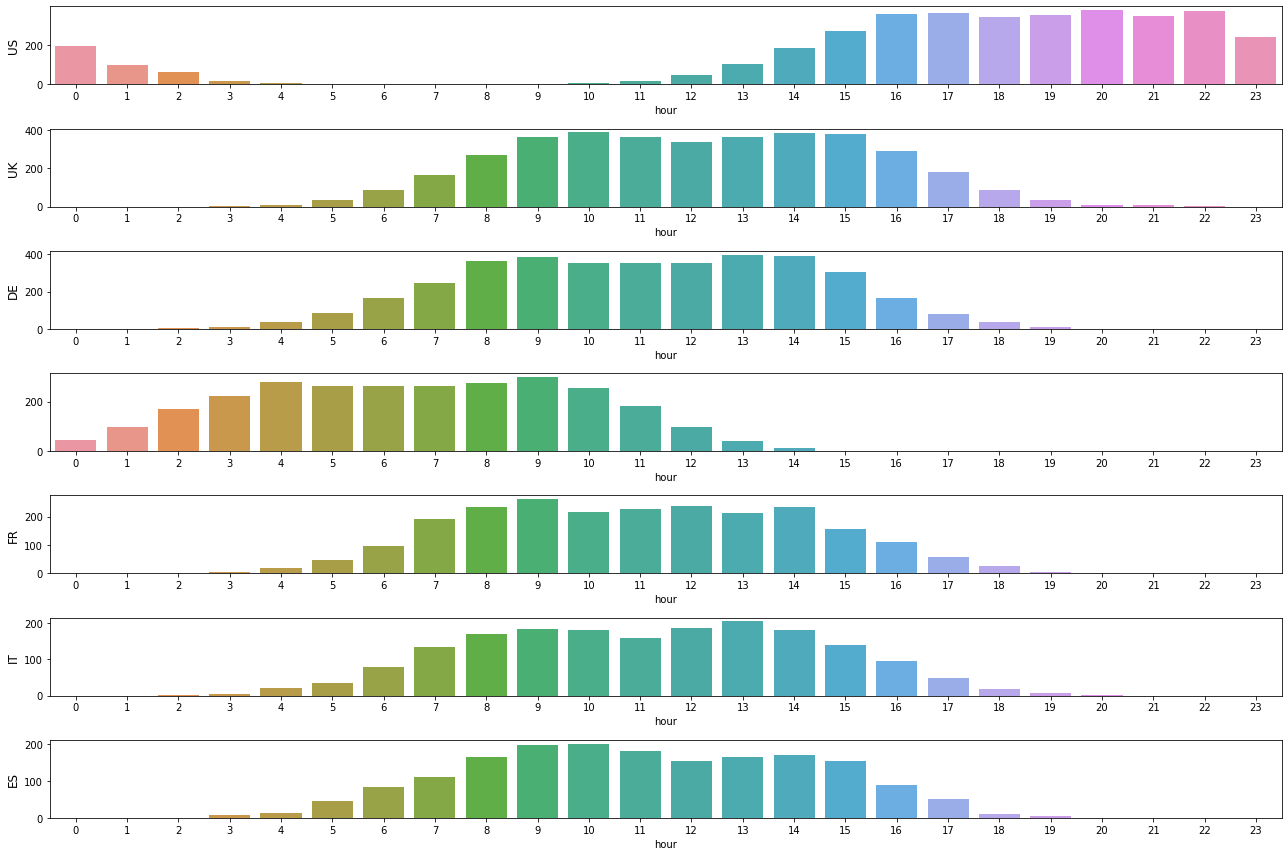

In [70]:
country_list = ['US', 'UK', 'DE', '', 'FR', 'IT', 'ES']
order = list(range(0, 24))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=12)
plt.tight_layout()
plt.show()

The peak time of this unknown country is around 5am, and the US peak time is around 6pm, so there is about 13 or 12 hour different betweeen them, so the missing country could probably going to be some country in Asia

# Q2
For each city, find the most likely city to be also searched for within the same session

In [104]:
cities = set({})
maps = {}
counter = 0
for index, row in data.iterrows():
    city_list = row['cities'].split(',')
    for i in city_list:
        i = i.strip()
        cities.add(i)
        if i not in maps:
            maps[i] = counter
            counter += 1


len(cities)

87

In [122]:
# calculate matrix similarity
pair_matrix = np.zeros((87, 87))
city_pair = data['cities'].apply(lambda x: x.split(', '))
for item in city_pair:
    #print(item)
    if len(item) == 1:
        continue
    else:
        for i in range(len(item) - 1):
            first_city = item[i]
            second_city = item[i+1]
            
            if first_city == second_city:
                print(first_city)
                print(second_city)
                print('---------------')
                continue
            else:
                for j in range(i+1, len(item)):
                    pair_matrix[maps[first_city], maps[second_city]] += 1
                    pair_matrix[maps[second_city], maps[first_city]] += 1
                    
df_sim = pd.DataFrame(pair_matrix, index=cities, columns=cities)
df_sim

,Toledo OH,Anaheim CA,Indianapolis IN,Tampa FL,Miami FL,Minneapolis MN,Newark NJ,Corpus Christi TX,Nashville TN,Saint Catharines-Niagara ON,...,Plano TX,Bakersfield CA,Virginia Beach VA,Milwaukee WI,Glendale AZ,Windsor ON,San Antonio TX,Oklahoma City OK,Omaha NE,Fort Wayne IN
Toledo OH,0.0,17.0,42.0,0.0,12.0,25.0,8.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anaheim CA,17.0,0.0,301.0,182.0,101.0,226.0,79.0,160.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indianapolis IN,42.0,301.0,0.0,0.0,264.0,422.0,171.0,322.0,71.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tampa FL,0.0,182.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Miami FL,12.0,101.0,264.0,0.0,0.0,143.0,75.0,113.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Windsor ON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0
San Antonio TX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
Oklahoma City OK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Omaha NE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0


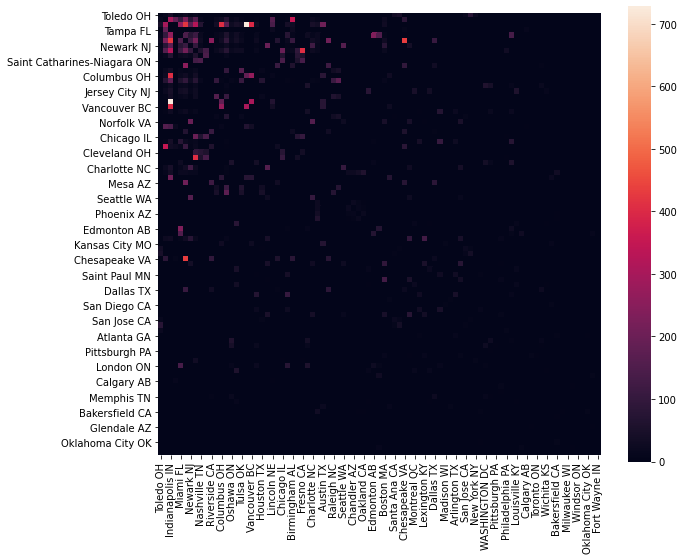

In [124]:
# visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_sim, ax=ax)
ax.axis('image')
plt.tight_layout()
plt.show()

As we can see from the scale, the lighter the color for each city and its pairs, the more possibility the user is going to search them together or the next time. 

In [185]:
def get_key(val):
    for key, value in maps.items():
         if val == value:
                return key
            
result = df_sim.apply(np.argmax, axis=1).reset_index()
result = result.rename(columns={'index': 'city', 0: 'most similar'})\

similar = []
for i in result['most similar']:
    similar.append(get_key(i))
result['most similar city'] = similar
result

,city,most similar,most similar city
0,Toledo OH,61,Oakland CA
1,Anaheim CA,26,OTTAWA ON
2,Indianapolis IN,17,Jersey City NJ
3,Tampa FL,1,Montreal QC
4,Miami FL,2,New York NY
...,...,...,...
82,Windsor ON,81,Lincoln NE
83,San Antonio TX,81,Lincoln NE
84,Oklahoma City OK,78,Atlanta GA
85,Omaha NE,43,Madison WI


# Q3
Travel sites are browsed by two kinds of users. Users who are actually planning a trip and
users who just dream about a vacation. The first ones have obviously a much higher
purchasing intent. Users planning a trip often search for cities close to each other, while
users who search for cities far away from each other are often just dreaming about a
vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much
more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes
sense, right?). Based on this idea, come up with an algorithm that clusters sessions into
two groups: high intent and low intent. Explain all assumptions you make along the way.

In [206]:
def calc_distance(cities):
    cities = cities.split(',')
    if len(cities) == 1:
        return 0
    
    distance = 0
    for i in range(len(cities) - 1):
        city1 = cities[i].strip()
        city2 = cities[i + 1].strip()
        distance += df_sim.loc[city1, city2]
        if distance != 0:
            distance = 1/distance
        #for j in range(i + 1, len(cities)):
    return distance/len(cities)

In [207]:
data['distance'] = data['cities'].apply(calc_distance)
data

,session_id,timestamp,cities,user_id,joining_date,country,time,hour,distance
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5,0.0
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8,0.0
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12,0.0
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13,0.0
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19,0.0
...,...,...,...,...,...,...,...,...,...
20017,LGO21SOLIFVIA,1435861080,Phoenix AZ,2636,2015-03-17,US,2015-07-02 18:18:00,18,0.0
20018,GQ4W7LU56MHXK,1436545154,OTTAWA ON,8144,2015-03-08,UK,2015-07-10 16:19:14,16,0.0
20019,N2FQ84QXOBFQM,1427625345,Indianapolis IN,4816,2015-03-29,DE,2015-03-29 10:35:45,10,0.0
20020,54RKP04D2OGDB,1442234943,Chicago IL,6812,2015-03-09,ES,2015-09-14 12:49:03,12,0.0


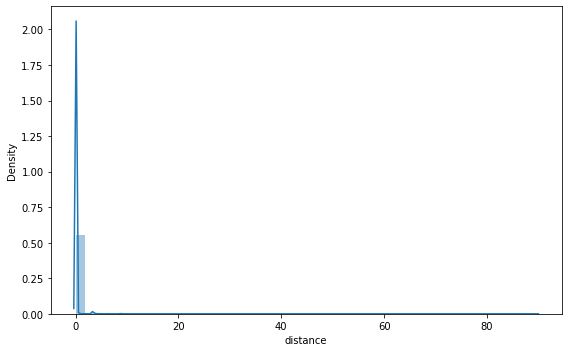

In [208]:
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data['distance'], ax=ax, bins=50)
plt.tight_layout()
plt.show()

[(0.0, 5.0)]

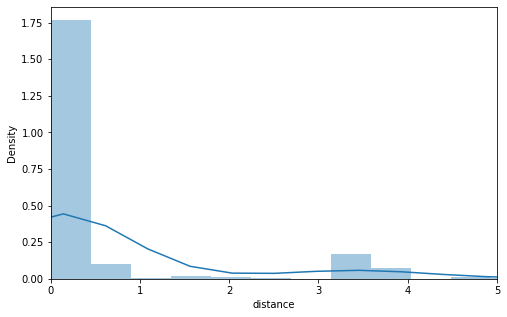

In [231]:
# filter out distance=0, because a lot of search with one city will have distance=0
# plt.xticks(0, 5)
# data['distance'][data['distance']>0].hist(bins=100,figsize=(12,6), density=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data['distance'][data['distance'] > 0], ax=ax, bins = 200)
ax.set(xlim=(0, 5))